In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# torchvision 을 통한 CIFAR10 다운로드
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
])

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

print(f"train dataset length = {len(training_data)}")
print(f"test  dataset length = {len(test_data)}")

cuda
Files already downloaded and verified
Files already downloaded and verified
train dataset length = 50000
test  dataset length = 10000


In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {y.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 32, 32]) torch.int64
Shape of y: torch.Size([64]) torch.int64


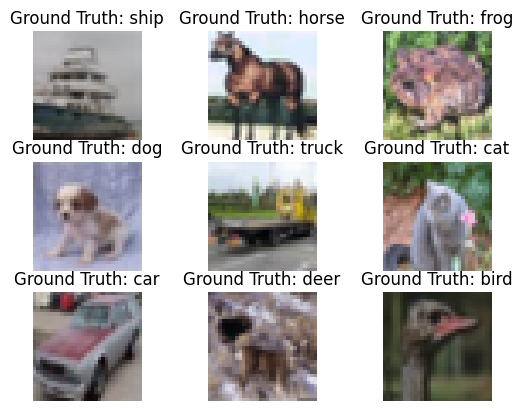

In [9]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).numpy(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)

In [10]:
#########################################################
# [EXERCISE] Create VGG-16 architecture (refer to part1)
#########################################################
class VGG16_cifar10(nn.Module):
    def __init__(self):
        super(VGG16_cifar10, self).__init__()

        self.conv_layers = nn.Sequential(            
            # C1
            # (input ch, output ch, filter size)
            nn.Conv2d(3, 4, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(4, 4, 3, padding=1),
            nn.ReLU(),

            # S1
            # pooling size (2,2)
            nn.MaxPool2d(2,2),

            # C3
            nn.Conv2d(4, 8, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, 3, padding=1),
            nn.ReLU(),

            # S2
            nn.MaxPool2d(2,2),

            # C5
            nn.Conv2d(8, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),

            # S3
            nn.MaxPool2d(2,2),

            # C7
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),

            # S4
            nn.MaxPool2d(2,2),

            # C10
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),

            # S5
            nn.MaxPool2d(2,2)
        )

        self.flatten = nn.Flatten()

        self.fc_layers = nn.Sequential(
            # F5
            nn.Linear(32, 16),
            nn.ReLU(),

            # F6
            nn.Linear(16, 10),
        )               

    def forward(self, x):
        x = self.conv_layers(x)
        # Converting multidimensional data to one dimension for FC operation
        x = self.flatten(x)
        logit = self.fc_layers(x)        
        return logit

model = VGG16_cifar10().to(device)
print(model)

VGG16_cifar10(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(

In [11]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 32, 32]             112
              ReLU-2            [-1, 4, 32, 32]               0
            Conv2d-3            [-1, 4, 32, 32]             148
              ReLU-4            [-1, 4, 32, 32]               0
         MaxPool2d-5            [-1, 4, 16, 16]               0
            Conv2d-6            [-1, 8, 16, 16]             296
              ReLU-7            [-1, 8, 16, 16]               0
            Conv2d-8            [-1, 8, 16, 16]             584
              ReLU-9            [-1, 8, 16, 16]               0
        MaxPool2d-10              [-1, 8, 8, 8]               0
           Conv2d-11             [-1, 16, 8, 8]           1,168
             ReLU-12             [-1, 16, 8, 8]               0
           Conv2d-13             [-1, 16, 8, 8]           2,320
             ReLU-14             [-1, 1

In [12]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred=pred.argmax(1)
            test_loss += loss_fn(pred, y).item()
            correct += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.312770  [    0/50000]
loss: 2.318304  [ 6400/50000]
loss: 2.300195  [12800/50000]
loss: 2.227091  [19200/50000]
loss: 2.224059  [25600/50000]
loss: 2.232345  [32000/50000]
loss: 1.890437  [38400/50000]
loss: 1.966645  [44800/50000]
Test Error: 
 Accuracy: 24.8%, Avg loss: 1.910950 

Epoch 2
-------------------------------
loss: 1.810210  [    0/50000]
loss: 1.943237  [ 6400/50000]
loss: 1.906796  [12800/50000]
loss: 1.955223  [19200/50000]
loss: 2.004865  [25600/50000]
loss: 1.807845  [32000/50000]
loss: 1.784666  [38400/50000]
loss: 1.863276  [44800/50000]
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.750592 

Epoch 3
-------------------------------
loss: 1.621762  [    0/50000]
loss: 1.580205  [ 6400/50000]
loss: 1.753614  [12800/50000]
loss: 1.633185  [19200/50000]
loss: 1.739780  [25600/50000]
loss: 1.875382  [32000/50000]
loss: 1.623969  [38400/50000]
loss: 1.590939  [44800/50000]
Test Error: 
 Accuracy: 35.6%, Avg loss: 1.667695 

Epoc

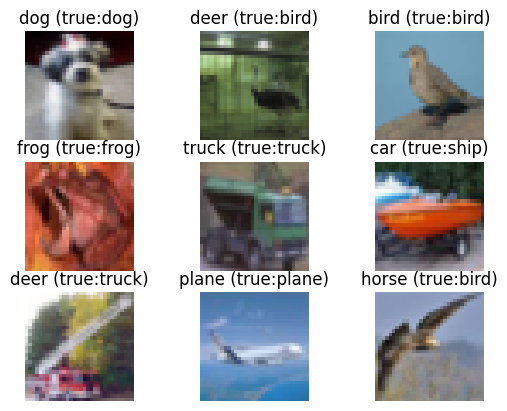

In [17]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)
pred = model(images)
predicted=pred.argmax(1)

figure = plt.figure()
num_of_images = 9

for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title(f"Ground Truth: {classes[labels[index]]}")
    plt.title(f"{classes[predicted[index].item()]} (true:{classes[labels[index]]})")
    plt.imshow(np.transpose((images[index] * 0.5 + 0.5).cpu().numpy().squeeze(), (1, 2, 0)))  # 출력을 위한 차원변환 (channels*rows*cols) -> (rows*cols*channels)


In [18]:
torch.save(model,"trained_VGG16(CIFAR10).pth")